# Edge Detection in colored vector space
### Implemented by: Rochak Saini, Aman Chauhan

This notebook contains the implementation of the following three methods:
1. http://people.csail.mit.edu/tieu/notebook/imageproc/dizenzo86.pdf **
2. The conventional canny operator
3. The default method for the colored edge detection.

The results of all the three methods are compared in the end. <br>
The images used to compare are:
1. The default 'Lena'.
2. An image with different colored RGB grids but all of similar intensity. <br>

Links for reading:
1. http://justin-liang.com/tutorials/canny/
2. http://www.aishack.in/tutorials/canny-edge-detector/ <br>
** The implementation and results of Method 1 can be improved to a great extent. 

In [18]:
import numpy, scipy, scipy.ndimage
from scipy.ndimage import filters
from scipy.ndimage import measurements
from numpy import *
import cv2
import sys
from pylab import *
import matplotlib.pyplot as plt
import imageio
import math
import warnings


In [19]:
warnings.filterwarnings("ignore")

In [20]:
## nonmaximum suppression
# Gm: gradient magnitudes
# Gd: gradient directions, 
# return: nms, gradient magnitude if local max, 0 otherwise
def nonmaxsupress(Gm, Gd, th=1.0):
    print("nonmaxsupress")
    nms = zeros(Gm.shape, Gm.dtype)   
    h,w = Gm.shape    
    for x in range(1, w-1):
        for y in range(1, h-1):            
            mag = Gm[y,x]
            if mag < th: continue        
            teta = Gd[y,x]            
            dx, dy = 0, -1      # abs(orient) >= 1.1781, teta < -67.5 degrees and teta > 67.5 degrees
            if abs(teta) <= 0.3927: dx, dy = 1, 0       # -22.5 <= teta <= 22.5
            elif teta < 1.1781 and teta > 0.3927: dx, dy = 1, 1     # 22.5 < teta < 67.5 degrees
            elif teta > -1.1781 and teta < -0.3927: dx, dy = 1, -1  # -67.5 < teta < -22.5 degrees            
            if mag > Gm[y+dy,x+dx] and mag > Gm[y-dy,x-dx]: nms[y,x] = mag    
    return nms

In [21]:

def detect_rgb(image, thLow, thHigh, gtype=0, binaryEdge=True):
    print("detect_rgb")
    Gm, Gd = rgb_gradient(image) 
    nms = nonmaxsupress(Gm, Gd, th=1.0)
    return Gm, nms

In [22]:
def gradient(image, type=0):
    print("gradient")
    if type==0:
        # Sobel fiter is used to find the gradient of the image. Other options: Prewitt filter
        Ix = filters.sobel(image, axis=1)
        Iy = filters.sobel(image, axis=0)
    return Ix, Iy

In [23]:

# gradient magnitudes and directions of a grayscale image
def gray_gradient(image):
    print("gray_gradient")
    Gx, Gy = gradient(image)
    Gm = sqrt(Gx**2+Gy**2)
    Gd = arctan2(Gy, Gx)    
    #Gd[Gd > 0.5*numpy.pi] -= numpy.pi
    #Gd[Gd < -0.5*numpy.pi] += numpy.pi
    return Gm, Gd

In [24]:
# maximum gradient for each pixel in all the channels
def multi_gradient_max(imgs):
    print("multi_gradient_max")
    N=len(imgs)      
    Gm,Gd = gray_gradient(imgs[0])
    for i in range(1, N):
        Gm2, Gd2 = gray_gradient(imgs[i])        
        ind= Gm2>Gm
        Gm[ind] = Gm2[ind]       
        Gd[ind] = Gd2[ind]
    return Gm, Gd

In [25]:
# gradient magnitude from an RGB image
# type: 0 (color tensor), else (max)
def rgb_gradient(image,sigma=0.5):
    print("rgb_gradient")
    r = image[:,:,0].astype('float32')
    g = image[:,:,1].astype('float32')
    b = image[:,:,2].astype('float32')
    
    imgs=[]
    imgs.append(r)
    imgs.append(g)
    imgs.append(b)
    return multi_gradient_max(imgs)

In [26]:
def dizenzo(gxx, gyy, gxy):
    print('dizenzo')
    x = 2*gxy/(gxx-gyy)
    theta = .5*np.arctan(x)
    return theta

In [27]:
def tensorComponents(Rx, Ry, Gx, Gy, Bx, By):
    print("tensorComponents")
    gxx = Rx*Rx+Gx*Gx+Bx*Bx
    gyy = Ry*Ry+Gy*Gy+By*By
    gxy = Rx*Ry+Gx*Gy+Bx+By
    return gxx, gyy, gxy

In [28]:
def gradients(imgs):
    print("gradients")
    Rx, Ry = gradient(imgs[0])
    Gx, Gy = gradient(imgs[1])
    Bx, By = gradient(imgs[2])
    return Rx, Ry, Gx, Gy, Bx, By

In [29]:
def zenzo_gradient(image):
    print("zenzo gradient")
    r = image[:,:,0].astype('float32')
    g = image[:,:,1].astype('float32')
    b = image[:,:,2].astype('float32')
    
    imgs=[]
    imgs.append(r)
    imgs.append(g)
    imgs.append(b)
    Rx, Ry, Gx, Gy, Bx, By = gradients(imgs)
    gxx, gyy, gxy = tensorComponents(Rx, Ry, Gx, Gy, Bx, By)
    theta = dizenzo(gxx, gyy, gxy)
    mag = (.5*((gxx+gyy) + ((gxx-gyy)*2*np.cos(theta)**2-1)) + (2*gxy*2*np.sin(theta)**2 -1))
    return mag

# 1. Lena

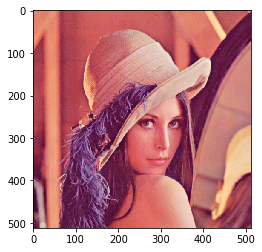

In [30]:
img = imageio.imread('lena.png')
plt.imshow(img)

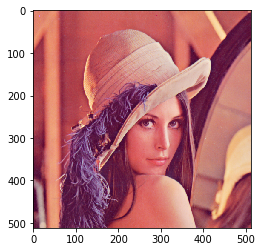

In [31]:
#Applying Gaussian filter to the image to smoothen it
sigma = .2
image = scipy.ndimage.filters.gaussian_filter(img, sigma)
plt.imshow(image)

In [32]:
print("Fuunctions are called in this order:")
zenzo = zenzo_gradient(image)

Fuunctions are called in this order:
zenzo gradient
gradients
gradient
gradient
gradient
tensorComponents
dizenzo


In [33]:
tlow = 10
thigh = 19
print('Functions are called in this order')
conv, nms = detect_rgb(image, tlow, thigh, 1)

Functions are called in this order
detect_rgb
rgb_gradient
multi_gradient_max
gray_gradient
gradient
gray_gradient
gradient
gray_gradient
gradient
nonmaxsupress


In [34]:
canny = cv2.Canny(image,25,255,L2gradient=False)

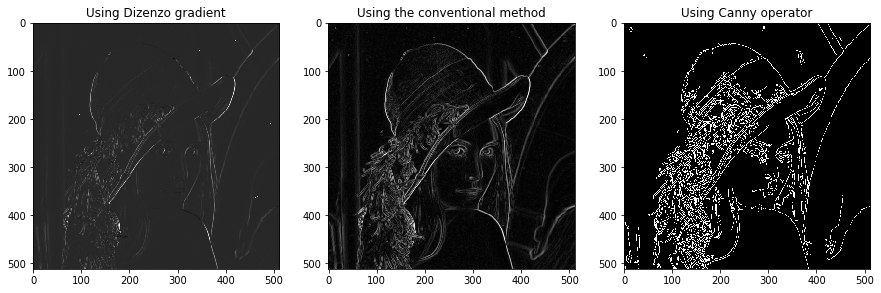

In [35]:
f, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax0.imshow(zenzo, cmap='gray')
ax0.set_title("Using Dizenzo gradient")
ax1.imshow(conv, cmap='gray')
ax1.set_title("Using the conventional method")
ax2.imshow(canny, cmap='gray')
ax2.set_title("Using Canny operator")
plt.show()

# 2. Bat Logo

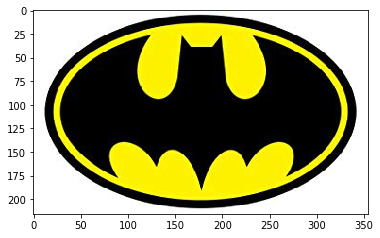

In [36]:
img = imageio.imread('lena4.jpg')
plt.imshow(img)

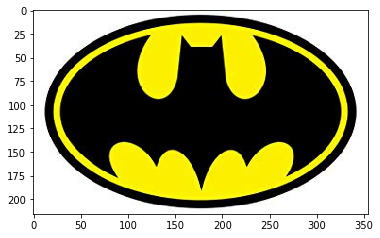

In [37]:
#Applying Gaussian filter to the image to smoothen it
sigma = .2
image = scipy.ndimage.filters.gaussian_filter(img, sigma)
plt.imshow(image)

In [38]:
print("Fuunctions are called in this order:")
zenzo = zenzo_gradient(image)

Fuunctions are called in this order:
zenzo gradient
gradients
gradient
gradient
gradient
tensorComponents
dizenzo


In [39]:
tlow = 10
thigh = 19
print('Functions are called in this order')
conv, nms = detect_rgb(image, tlow, thigh, 1)

Functions are called in this order
detect_rgb
rgb_gradient
multi_gradient_max
gray_gradient
gradient
gray_gradient
gradient
gray_gradient
gradient
nonmaxsupress


In [40]:
canny = cv2.Canny(image,25,255,L2gradient=False)

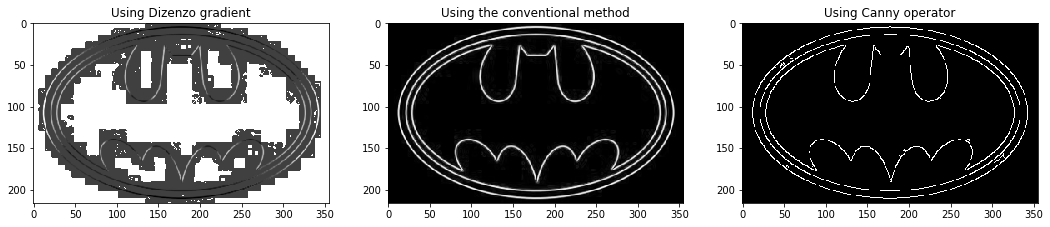

In [41]:
f, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
ax0.imshow(zenzo, cmap='gray')
ax0.set_title("Using Dizenzo gradient")
ax1.imshow(conv, cmap='gray')
ax1.set_title("Using the conventional method")
ax2.imshow(canny, cmap='gray')
ax2.set_title("Using Canny operator")
plt.show()

Again, something(implemetation/code) for Method1 is not perfect and the plot confirms that

# The below image contains different RGB values but the intensity of the colors are same

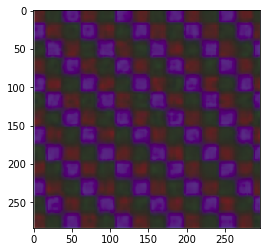

In [42]:
img = imageio.imread('lena5.png')
#Applying Gaussian filter to the image to smoothen it
sigma = .2
image = scipy.ndimage.filters.gaussian_filter(img, sigma)
plt.imshow(image)

In [43]:
print("Fuunctions are called in this order:")
zenzo = zenzo_gradient(image)

Fuunctions are called in this order:
zenzo gradient
gradients
gradient
gradient
gradient
tensorComponents
dizenzo


In [44]:
tlow = 10
thigh = 19
print('Functions are called in this order')
conv, nms = detect_rgb(image, tlow, thigh, 1)

Functions are called in this order
detect_rgb
rgb_gradient
multi_gradient_max
gray_gradient
gradient
gray_gradient
gradient
gray_gradient
gradient
nonmaxsupress


In [45]:
canny = cv2.Canny(image,25,255,L2gradient=False)

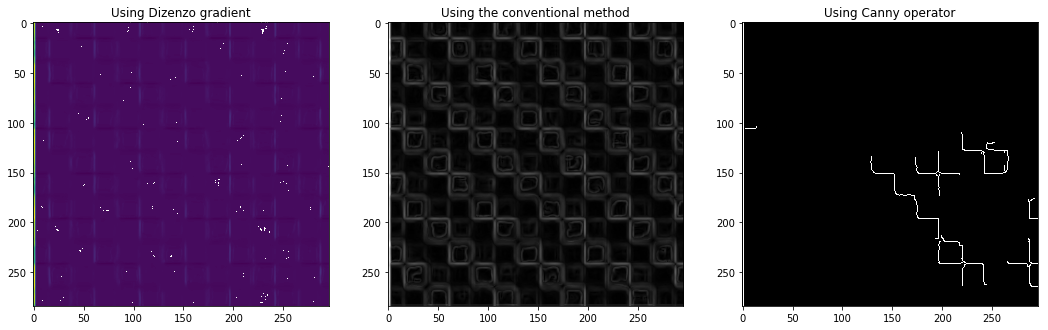

In [46]:
f, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
ax0.imshow(zenzo)
ax0.set_title("Using Dizenzo gradient")
ax1.imshow(conv, cmap='gray')
ax1.set_title("Using the conventional method")
ax2.imshow(canny, cmap='gray')
ax2.set_title("Using Canny operator")
plt.show()

As expected, the canny operator fails in this image and the vector based techniques are much more efficient while dealing with colored images. <br>
Work that needs to be done:
1. Method1: Something wrong with the expression to calculate the gradient image.
2. Method2: Non max Suppression and hystersis thresholding.